In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

color_pal=sns.color_palette()

# Target Augmentation for multi-step forecast



In [2]:
df = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv')
df_eval =pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/test.csv')

NUMBER_OF_STORES=df['store'].nunique()
NUMBER_OF_ITEMS=df['item'].nunique()

for store in range(NUMBER_OF_STORES):
  store_sales=df.loc[df['store']==store+1].groupby('date')['sales'].sum()
  df[f'sale_at_store_{store+1}']=df['date'].map(store_sales)

for item in range(NUMBER_OF_ITEMS):
  item_sales=df.loc[df['item']==item+1].groupby('date')['sales'].sum()
  df[f'sale_of_item_{item+1}']=df['date'].map(item_sales)


print(df.columns)

def store_condition(row):
  store=row['store']
  return row[f'sale_at_store_{store}']

def item_condition(row):
  item=row['item']
  return row[f'sale_of_item_{item}']


df['date']=pd.to_datetime(df['date'])
df['store']=df['store'].astype('category')
df['item']=df['item'].astype('category')


df['total_sale_by_item']=df.apply(item_condition,axis=1)
df['total_sale_by_store']=df.apply(store_condition,axis=1)



for store in range(NUMBER_OF_STORES):
  df=df.drop(f'sale_at_store_{store+1}',axis=1)

for item in range(NUMBER_OF_ITEMS):
   df=df.drop(f'sale_of_item_{item+1}',axis=1)


print(df.head())



Index(['date', 'store', 'item', 'sales', 'sale_at_store_1', 'sale_at_store_2',
       'sale_at_store_3', 'sale_at_store_4', 'sale_at_store_5',
       'sale_at_store_6', 'sale_at_store_7', 'sale_at_store_8',
       'sale_at_store_9', 'sale_at_store_10', 'sale_of_item_1',
       'sale_of_item_2', 'sale_of_item_3', 'sale_of_item_4', 'sale_of_item_5',
       'sale_of_item_6', 'sale_of_item_7', 'sale_of_item_8', 'sale_of_item_9',
       'sale_of_item_10', 'sale_of_item_11', 'sale_of_item_12',
       'sale_of_item_13', 'sale_of_item_14', 'sale_of_item_15',
       'sale_of_item_16', 'sale_of_item_17', 'sale_of_item_18',
       'sale_of_item_19', 'sale_of_item_20', 'sale_of_item_21',
       'sale_of_item_22', 'sale_of_item_23', 'sale_of_item_24',
       'sale_of_item_25', 'sale_of_item_26', 'sale_of_item_27',
       'sale_of_item_28', 'sale_of_item_29', 'sale_of_item_30',
       'sale_of_item_31', 'sale_of_item_32', 'sale_of_item_33',
       'sale_of_item_34', 'sale_of_item_35', 'sale_of_item_


We are going to implement a multi-step forecast model. We will first pr the total sale at each store, and lastly the sale of individual items.edict the mean sale of each item, then

# Feature Engineering

In [3]:

def create_features(df):
    df = df.copy()
    df['day']=df.index.day
    df['month']=df.index.month
    df['year']=df.index.year
    df['dayofweek']=df.index.dayofweek
    df['dayofyear']=df.index.dayofyear
    week_data = df.index.isocalendar()
    df['weekofyear'] = week_data['week'].astype(int)
    df['quarter']=df.index.quarter
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df



In [4]:
df=df.set_index('date')



In [5]:
df=create_features(df)
print(df.head())

           store item  sales  total_sale_by_item  total_sale_by_store  day  \
date                                                                         
2013-01-01     1    1     13                 133                 1316    1   
2013-01-02     1    1     11                  99                 1264    2   
2013-01-03     1    1     14                 127                 1305    3   
2013-01-04     1    1     13                 145                 1452    4   
2013-01-05     1    1     10                 149                 1499    5   

            month  year  dayofweek  dayofyear  weekofyear  quarter  month_sin  \
date                                                                            
2013-01-01      1  2013          1          1           1        1        0.5   
2013-01-02      1  2013          2          2           1        1        0.5   
2013-01-03      1  2013          3          3           1        1        0.5   
2013-01-04      1  2013          4          4   

In [6]:
cutoff='2017-09-01'
train_df = df.loc[df.index<cutoff]
test_df = df.loc[df.index>=cutoff]


# MULTISTEP REGRESSOR MODEL

In [7]:
Features= ['store', 'item', 'day', 'month', 'year', 'dayofweek','dayofyear', 'weekofyear', 'quarter','month_sin','month_cos',
           'predicted_total_sale_by_store','predicted_total_sale_by_item']

Target = ['sales']

Features_store = ['store', 'day', 'month', 'year', 'dayofweek','dayofyear', 'weekofyear', 'quarter', 'month_sin', 'month_cos']
Target_store= ['total_sale_by_store']

Features_item= ['item','day', 'month', 'year', 'dayofweek','dayofyear', 'weekofyear', 'quarter', 'month_sin', 'month_cos']
Target_item = ['total_sale_by_item']



In [8]:
import pandas as pd

X_train_store = train_df[Features_store]
y_train_store = train_df[Target_store]
X_test_store = test_df[Features_store]
y_test_store = test_df[Target_store]

X_train_item = train_df[Features_item]
y_train_item = train_df[Target_item]
X_test_item = test_df[Features_item]
y_test_item = test_df[Target_item]


print(X_train_store.head())

# Remove duplicates in feature DataFrames
X_train_store = X_train_store.drop_duplicates().reset_index(drop=True)
X_test_store = X_test_store.drop_duplicates().reset_index(drop=True)
X_train_item = X_train_item.drop_duplicates().reset_index(drop=True)
X_test_item = X_test_item.drop_duplicates().reset_index(drop=True)

# Remove duplicates in target variables based on the feature DataFrames' index
y_train_store = y_train_store.iloc[X_train_store.index]
y_test_store = y_test_store.iloc[X_test_store.index]
y_train_item = y_train_item.iloc[X_train_item.index]
y_test_item = y_test_item.iloc[X_test_item.index]




           store  day  month  year  dayofweek  dayofyear  weekofyear  quarter  \
date                                                                            
2013-01-01     1    1      1  2013          1          1           1        1   
2013-01-02     1    2      1  2013          2          2           1        1   
2013-01-03     1    3      1  2013          3          3           1        1   
2013-01-04     1    4      1  2013          4          4           1        1   
2013-01-05     1    5      1  2013          5          5           1        1   

            month_sin  month_cos  
date                              
2013-01-01        0.5   0.866025  
2013-01-02        0.5   0.866025  
2013-01-03        0.5   0.866025  
2013-01-04        0.5   0.866025  
2013-01-05        0.5   0.866025  


# STORE SALE REGRESSOR

In [9]:
reg_store = xgb.XGBRegressor(enable_categorical=True,
                             tree_method='hist',
                             max_cat_to_onehot=1,
                             n_estimators=2000,
                             early_stopping_rounds=50,
                             learning_rate=0.01,gamma=0.1, reg_lambda=0.6,reg_alpha=0.6, subsample=0.8,max_depth=6,min_child_weight=3)
reg_store.fit(X_train_store,y_train_store,
        eval_set=[(X_test_store,y_test_store)],
        verbose=50)

[0]	validation_0-rmse:2900.03664
[50]	validation_0-rmse:1849.21166
[100]	validation_0-rmse:1203.56189
[150]	validation_0-rmse:800.46582
[200]	validation_0-rmse:551.94596
[250]	validation_0-rmse:387.15420
[300]	validation_0-rmse:278.54180
[350]	validation_0-rmse:204.16899
[400]	validation_0-rmse:157.75100
[450]	validation_0-rmse:128.68340
[500]	validation_0-rmse:111.35634
[550]	validation_0-rmse:99.94443
[600]	validation_0-rmse:93.09917
[650]	validation_0-rmse:88.40300
[700]	validation_0-rmse:85.48109
[750]	validation_0-rmse:82.96008
[800]	validation_0-rmse:81.13814
[850]	validation_0-rmse:79.88760
[900]	validation_0-rmse:79.17199
[950]	validation_0-rmse:78.41549
[1000]	validation_0-rmse:77.82479
[1050]	validation_0-rmse:77.29906
[1100]	validation_0-rmse:77.17050
[1150]	validation_0-rmse:77.10647
[1200]	validation_0-rmse:76.73469
[1250]	validation_0-rmse:76.46222
[1300]	validation_0-rmse:76.31658
[1350]	validation_0-rmse:76.18352
[1400]	validation_0-rmse:76.02251
[1450]	validation_0-rms

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=1, max_delta_step=None,
             max_depth=6, max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

# ITEM SALE REGRESSOR

In [10]:
reg_item = xgb.XGBRegressor(enable_categorical=True,tree_method='hist',
                       max_cat_to_onehot=1,
                       n_estimators=1500,
                       early_stopping_rounds=50,
                       learning_rate=0.01,gamma=0.1, reg_lambda=0.6,reg_alpha=0.6, subsample=0.8,max_depth=6,min_child_weight=3)
reg_item.fit(X_train_item,y_train_item,
        eval_set=[(X_test_item,y_test_item)],
        verbose=50)

[0]	validation_0-rmse:379.91944
[50]	validation_0-rmse:241.91372
[100]	validation_0-rmse:157.64579
[150]	validation_0-rmse:105.83557
[200]	validation_0-rmse:73.37397
[250]	validation_0-rmse:53.57036
[300]	validation_0-rmse:40.76854
[350]	validation_0-rmse:32.72345
[400]	validation_0-rmse:27.95392
[450]	validation_0-rmse:25.50730
[500]	validation_0-rmse:23.95760
[550]	validation_0-rmse:23.11875
[600]	validation_0-rmse:22.56484
[650]	validation_0-rmse:22.29224
[700]	validation_0-rmse:22.14985
[750]	validation_0-rmse:22.11924
[800]	validation_0-rmse:22.06221
[850]	validation_0-rmse:22.05250
[894]	validation_0-rmse:22.11264


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=1, max_delta_step=None,
             max_depth=6, max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

# Individual Sale Regressor

In [11]:
train_df['predicted_total_sale_by_store']=reg_store.predict(train_df[Features_store])
train_df['predicted_total_sale_by_item']=reg_item.predict(train_df[Features_item])
test_df['predicted_total_sale_by_store']=reg_store.predict(test_df[Features_store])
test_df['predicted_total_sale_by_item']=reg_item.predict(test_df[Features_item])

X_train = train_df[Features]
y_train = train_df[Target]
X_test = test_df[Features]
y_test = test_df[Target]

/tmp/ipykernel_20/2906402638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['predicted_total_sale_by_store']=reg_store.predict(train_df[Features_store])
/tmp/ipykernel_20/2906402638.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['predicted_total_sale_by_item']=reg_item.predict(train_df[Features_item])
/tmp/ipykernel_20/2906402638.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [12]:
reg= xgb.XGBRegressor(enable_categorical=True,
                      tree_method='hist',
                      max_cat_to_onehot=1,
                      n_estimators=1500,
                      early_stopping_rounds=50,
                      learning_rate=0.01,
                      gamma=0.1,
                      reg_lambda=0.6,
                      reg_alpha=0.6,
                      subsample=0.8,
                      max_depth=6,
                      min_child_weight=3)

reg.fit(X_train,y_train,
        eval_set=[(X_train,y_train),(X_test,y_test)],
        verbose=50)

[0]	validation_0-rmse:58.34751	validation_1-rmse:62.64136
[50]	validation_0-rmse:35.84198	validation_1-rmse:38.72070
[100]	validation_0-rmse:22.48289	validation_1-rmse:24.50471
[150]	validation_0-rmse:14.79383	validation_1-rmse:16.28333
[200]	validation_0-rmse:10.64533	validation_1-rmse:11.78712
[250]	validation_0-rmse:8.62872	validation_1-rmse:9.52750
[300]	validation_0-rmse:7.75392	validation_1-rmse:8.48424
[350]	validation_0-rmse:7.40470	validation_1-rmse:8.02706
[400]	validation_0-rmse:7.27097	validation_1-rmse:7.82784
[450]	validation_0-rmse:7.21992	validation_1-rmse:7.73822
[500]	validation_0-rmse:7.19994	validation_1-rmse:7.69527
[550]	validation_0-rmse:7.19143	validation_1-rmse:7.67357
[600]	validation_0-rmse:7.18711	validation_1-rmse:7.66183
[650]	validation_0-rmse:7.18429	validation_1-rmse:7.65578
[700]	validation_0-rmse:7.18198	validation_1-rmse:7.65222
[750]	validation_0-rmse:7.17986	validation_1-rmse:7.64963
[800]	validation_0-rmse:7.17788	validation_1-rmse:7.64837
[850]	v

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=1, max_delta_step=None,
             max_depth=6, max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

In [13]:
fi=pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

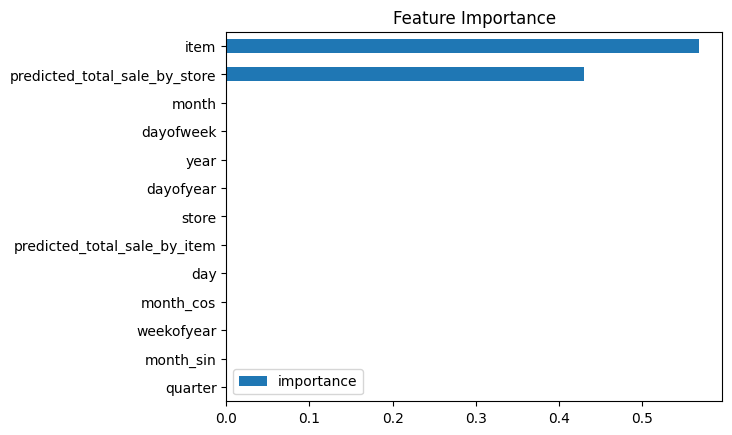

In [14]:
fi.sort_values('importance').plot(kind='barh',title='Feature Importance')
plt.show()

# Forecasting

In [15]:
df_eval=df_eval.set_index('date')

df_eval.index=pd.to_datetime(df_eval.index)
df_eval['store']=df_eval['store'].astype('category')
df_eval['item']=df_eval['item'].astype('category')

df_eval = create_features(df_eval)

print(df_eval.head())

            id store item  day  month  year  dayofweek  dayofyear  weekofyear  \
date                                                                            
2018-01-01   0     1    1    1      1  2018          0          1           1   
2018-01-02   1     1    1    2      1  2018          1          2           1   
2018-01-03   2     1    1    3      1  2018          2          3           1   
2018-01-04   3     1    1    4      1  2018          3          4           1   
2018-01-05   4     1    1    5      1  2018          4          5           1   

            quarter  month_sin  month_cos  
date                                       
2018-01-01        1        0.5   0.866025  
2018-01-02        1        0.5   0.866025  
2018-01-03        1        0.5   0.866025  
2018-01-04        1        0.5   0.866025  
2018-01-05        1        0.5   0.866025  


In [16]:
df_eval['predicted_total_sale_by_store']=reg_store.predict(df_eval[Features_store])
df_eval['predicted_total_sale_by_item']=reg_item.predict(df_eval[Features_item])
df_eval['sales']= reg.predict(df_eval[Features])

In [17]:
submission=df_eval[['id','sales']]
print(submission.head())

            id      sales
date                     
2018-01-01   0  11.620783
2018-01-02   1  14.188237
2018-01-03   2  14.155778
2018-01-04   3  14.940560
2018-01-05   4  16.177734


In [18]:
submission.to_csv('submission.csv', index=False)
